# OilyGiant Oil Well Region Selection

# Introduction

My task is to choose the best region for 200 new oil wells, from a set of three regions, each of which has a large number of observations regarding oil quality and volume. The best region is defined as the region with the highest profit margin; revenue will be calculated using data from the 200 best-performing observations, with measured risk calculated as a loss and development costs being a constant.

First I will preprocess the data, verifying its suitability for training. For each region I will train and validate a linear regression model, save the predictions and correct values, and evaluate the models using root mean squared error and r^2 score.

Then I will calculate how much oil is necessary to make a profit, and estimate the amount of oil in 200 wells using the average oil well size.

After that I will select only the largest 200 oil wells and calculate the actual profits from these. Then I will take risk into account, using bootstrapping to find the confidence interval and evaluating the risks of losses. The final region must have a risk of loss no greater than 2.5%.

In [1]:
import pandas as pd
from numpy.random import RandomState
from numpy import format_float_scientific as sc
from numpy import percentile
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing

I need to import the datasets and examine them for duplicate observations and missing values. I will one-hot encode any categorical features and standardize numeric features. I will split the datasets into features and target. I will also create some lists of the three datasets, so that when I write functions later, I can use these lists as input. 

In [2]:
try:
    df_0 = pd.read_csv('geo_data_0.csv')
except:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    
try:    
    df_1 = pd.read_csv('geo_data_1.csv')
except:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')

try:    
    df_2 = pd.read_csv('geo_data_2.csv')
except:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

df_list = [df_0, df_1, df_2]

Check out preview of the datasets.

In [3]:
i = 0
for df in df_list:
    print(f"For region {i}:")
    print(df.head())
    print()
    i += 1

For region 0:
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

For region 1:
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

For region 2:
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



From the first few rows, it seems to me that the numeric features are already somewhat standardized, and there are no categorical features. The id can be dropped; f0, f1, and f2 are the features; and, product (thousand barrels of oil) is the target.

Check for duplicates using a loop. Print out the number of duplicate rows and duplicate id's.

In [4]:
i = 0
for df in df_list:
    print(f"For region {i}:")
    
    print("Duplicate observations:", df.duplicated().sum())
    print("Duplicate id's:", df.id.duplicated().sum())
    print()
    
    # print(df[df.id.duplicated()])
    # print()
    
    i += 1

For region 0:
Duplicate observations: 0
Duplicate id's: 10

For region 1:
Duplicate observations: 0
Duplicate id's: 4

For region 2:
Duplicate observations: 0
Duplicate id's: 4



It is possible that some of the potential oil well sites had multiple samples taken. Because these duplicate id's have different data attached to them, I will keep them in. However, I will keep lists of these id's and later in the project, I will make sure to adjust the final results, if necessary, to have 200 unique oil well spots as desired by the company.

In [5]:
dup_sites_0 = df_0[df_0.id.duplicated()][['id']]
dup_sites_1 = df_1[df_1.id.duplicated()][['id']]
dup_sites_2 = df_2[df_2.id.duplicated()][['id']]

Let's check for missing values and datatypes now.

In [6]:
i = 0
for df in df_list:
    print(f"For region {i}:")
    df.info()
    print()
    
    i += 1

For region 0:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

For region 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

For region 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data column

Excellent - no missing values, and the features/target are all floats.

I'm curious about how the features correlate with the products.

In [7]:
df_0.corr(numeric_only=True)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [8]:
df_1.corr(numeric_only=True)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [9]:
df_2.corr(numeric_only=True)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Hmm, f2 seems to correlate the most, especially in region 1, where is there is an extremely high positive correlation. I expect the linear regression model for region 1 to perform well, based on the high correlation of its f2 with its target.

# Model Training

Now I will train a linear regression model for each of these datasets, using a function.

In [10]:
def train_model(df):
    
    """
    This function takes one of our three pandas DataFrames as input, splits it into features and target,
    further splits these into training/validation sets (0.75/0.25), trains a linear regression model, 
    makes predictions, saves the predictions and the answers, and prints average predicted reserve volume, root mean squared error, 
    and R2 score. This function returns a tuple in the format (predictions, answers, model, average volume).
    """
    
    features = df[['f0', 'f1', 'f2']]
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=0)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, pred)**0.5
    score = r2_score(target_valid, pred)
    avg_vol = pred.mean()
    answers = pd.Series(target_valid).reset_index(drop=True)
    
    print("Average volume of predicted reserves:", avg_vol)
    print("RMSE:", rmse)
    print("R2 score:", score)
    print()
    
    return pd.Series(pred), answers, model, avg_vol

In [11]:
region_0_pred, region_0_answers, region_0_model, region_0_avg_vol = train_model(df_0)

Average volume of predicted reserves: 92.27144852242301
RMSE: 37.48100896950594
R2 score: 0.2809263356941697



In [12]:
region_1_pred, region_1_answers, region_1_model, region_1_avg_vol = train_model(df_1)

Average volume of predicted reserves: 69.15162398290752
RMSE: 0.8872573052219335
R2 score: 0.9996271830439484



In [13]:
region_2_pred, region_2_answers, region_2_model, region_2_avg_vol = train_model(df_2)

Average volume of predicted reserves: 94.70753129105672
RMSE: 40.31290686044374
R2 score: 0.19438402105974983



Region 2 has the largest predicted volume, but the worst RMSE and R2 score. Region 1 has by far the best RMSE and R2 scores, but notably lower predicted reserve volume than the others. Region 0 has a slightly lower predicted reserve volume than region 2, but a somewhat better RMSE and R2 score than region 2.

To sum: region 2 has the most projected volume, region 1's model seems to be the most reliable, and region 0 is somewhere in the middle.

# Prepare for profit calculation

I'll store some of our values into variables for later ease of use, and figure out how much volume of oil is needed to break even. (Where revenue = development cost)

In [14]:
usd_per_1000_barrels = 4500
dev_cost = 10**8

Development cost is 100,000,000 USD for the planned 200 oil wells. In the datasets, the volume of oil is measured in 1000 barrels. One barrel provides 4.5 USD in revenue, so 1000 barrels provides 4,500 USD in revenue. Development cost divided by the revenue per 1000 barrels gives us the volume needed to break even.

In [15]:
min_volume = dev_cost / usd_per_1000_barrels
print(round(min_volume))

22222


The top 200 reserves in the region need to have a combined volume of at least 22,222 thousand barrels for a profit to be made.

The models gave predictions for the average volume of each predicted reserve. Let's multiply these values by 200.

In [16]:
print('Region 0 predicted total volume:', region_0_avg_vol*200)
print('Region 1 predicted total volume:', region_1_avg_vol*200)
print('Region 2 predicted total volume:', region_2_avg_vol*200)

Region 0 predicted total volume: 18454.289704484603
Region 1 predicted total volume: 13830.324796581504
Region 2 predicted total volume: 18941.506258211346


Going off of the average predicted volume, none of these regions seem to have enough oil to justify building oil wells. However, realistically we will be able to choose the best 200 sites possible for oil wells, so these total predicted volumes should be higher.

# Calculate profit from the top 200 wells

Let's write a function to find profit given oil wells are built at the top 200 predicted oil sites. We need to find the top 200 sites that the model would predict we should build on, and calculate profit based on the real-life values at these sites.

In [17]:
def top_200_profits(predictions, answers, show='yes'):
    
    """
    This function takes predictions and answers as input. The top 200 predicted sites are collected, and revenue is calculated from 
    the real-life values from these wells, based on the sum of the oil product and the $4500 per 1000 barrels value. Profit is found by 
    subtracting the $100 mil development costs from the revenue. Profit is returned.
    In this step, the total reserve volume and profit are printed.
    """
    
    top_200_pred_sites = predictions.sort_values(ascending=False).head(200).index
    top_200_sites_sum = answers[top_200_pred_sites].sum()
    revenue = top_200_sites_sum * usd_per_1000_barrels
    profit = revenue - dev_cost
    if show == 'yes':
        print("Total reserve volume:", top_200_sites_sum)
        print("Profit:", sc(round(profit)))
    return profit

In [18]:
region_0_profit = top_200_profits(region_0_pred, region_0_answers)

Total reserve volume: 29696.462399128774
Profit: 3.3634081e+07


33.6 million USD profit for region 0

In [19]:
region_1_profit = top_200_profits(region_1_pred, region_1_answers)

Total reserve volume: 27589.081548181137
Profit: 2.4150867e+07


24.2 million USD profit for region 1

In [20]:
region_2_profit = top_200_profits(region_2_pred, region_2_answers)

Total reserve volume: 28053.06374114759
Profit: 2.6238787e+07


26.2 million USD profit for region 2

All three regions have total reserve volume greater than 22,222 thousand barrels, and so therefore, all regions will yield a profit. Region 0 looks like by far the most promising in terms of profit. However, we still need to factor in the risk introduced by the imperfect prediction systems. The model for region 1 had a very high r^2 score compared to that of the others, despite having the lowest preliminary profit. We will add risk into our calculations with bootstrapping.

# Bootstrapping

Now I will look at risk using bootstrapping. Bootstrapping is a technique that can be used to evaluate machine learning models, where many subsamples are generated from the predictions and the answer, and a certain value (in this case, profit) is collected from each subsample. Calculations can be performed on this series to find, in this case, mean and confidence interval, and other values that may be desired. I will calculate the risks of losses for each region, which is the probability that there will be a negative profit, and filter the regions by eliminating regions with risk of loss greater than 2.5%, and then selecting the region with the highest average profit.

In [21]:
def bootstrap(predictions, answers):
    
    """
    This function takes predictions and answers as inputs, and is meant to be used to find values for specifically
    the three regions being examined in this notebook. It uses bootstrapping to calculate the mean and 95% confidence interval.
    It also iterates through quantiles to determine the approximate quantile where profit is zero.
    It prints the mean profit, 95% confidence interval, and risk of loss, and returns nothing.
    It displays a histogram of the average profits from the subsamples.
    """
    
    state = RandomState(0)
    values = []
    
#     1000 times, 500 samples will be taken from the target validation set, and profit will be calculated
# based on the top 200 of these samples. The samples will not be replaced, because there cannot be multiple 
# oil wells on a single site. I choose not to print values each time this iterates.
    for i in range(1000):
        answers_subsample = answers.sample(n=500, random_state=state, replace=False)
        pred_subsample = predictions[answers_subsample.index]
        profit = top_200_profits(pred_subsample, answers_subsample, show='no')
        
        values.append(profit)
    
    values = pd.Series(values)
    mean = round(values.mean())
    lower = round(values.quantile(0.025))
    upper = round(values.quantile(0.975))
    
    print("Average profit:", sc(mean), "USD")
    print(f"For 95% confidence interval, the lower profit is {sc(lower)} USD and the upper profit is {sc(upper)} USD.")
    
#     Iterate through quantiles until a profit of about 0 is reached, and record this quantile as a probability percentage.
    final_prof = 0
    final_i = 0
    for q in range (1,100,1):
        prof = values.quantile(q/1000)
        if prof >= 0:
            final_prof = prof
            final_q = q
            break
    print(f"Risk of loss: {q/10}%")
    
    values.hist(figsize=(5,3))
    plt.title("Distribution of profits")
    plt.xlabel("Profit made (USD)")
    plt.ylabel("How often was this profit made?")

Average profit: 4.319736e+06 USD
For 95% confidence interval, the lower profit is -9.59846e+05 USD and the upper profit is 9.241124e+06 USD.
Risk of loss: 4.8%


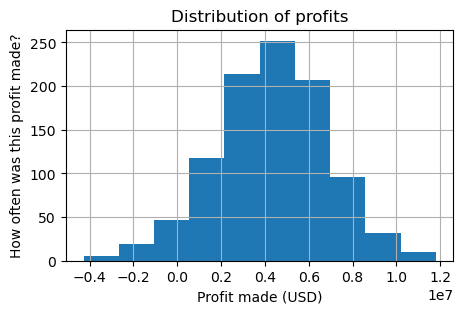

In [22]:
bootstrap(region_0_pred, region_0_answers)

Average profit: 4.812064e+06 USD
For 95% confidence interval, the lower profit is 9.15933e+05 USD and the upper profit is 8.735898e+06 USD.
Risk of loss: 1.2%


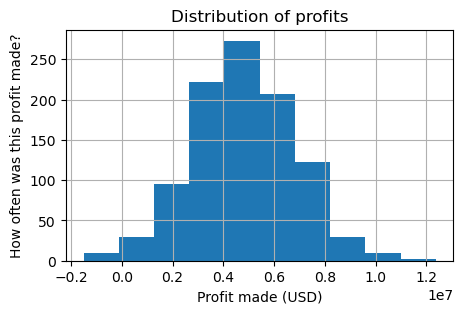

In [23]:
bootstrap(region_1_pred, region_1_answers)

Average profit: 3.845335e+06 USD
For 95% confidence interval, the lower profit is -1.483078e+06 USD and the upper profit is 9.035867e+06 USD.
Risk of loss: 7.8%


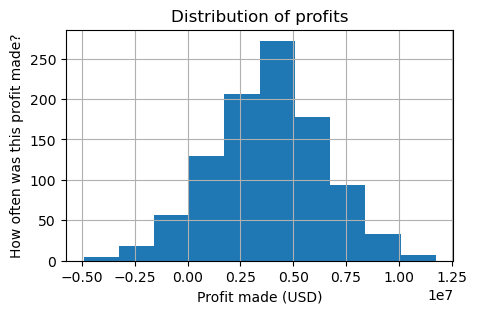

In [24]:
bootstrap(region_2_pred, region_2_answers)

Based on average profit from 200 oil wells, and the risk of loss, region 1 seems to be the best region for building oil wells. It only has a 1.2% risk of loss, compared to the others which have between about 5-8% risk, and also has the highest average profit.

# Conclusion

We have trained and validated linear regression models for each of the three regions for which we have data. We saved the predictions from these models and used the predictions to find the profit from the actual wells. We used bootstrapping to evaluate the risk of losses, and found that region 1 has both the lowest risk of loss (1.2%) and the highest average profit (4.8 million USD).